# Fitting STRFs with an OutStruct

This tutorial shows some of the basics of fitting STRFs and getting their predictions for neural data in an OutStruct

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import naplib as nl

In [2]:
filepath = '../out_structs/out_struct_sample.mat'
out = nl.io.import_outstruct(filepath)
print(f'This out struct has data for {len(out)} trials')

This out struct has data for 18 trials


In [3]:
# This out struct contains the fields 'aud' and 'resp', which give the stimulus and neural responses
print(f"aud stimulus shape for first trial : {out[0]['aud'].shape}")
print(f"response shape for first trial : {out[0]['resp'].shape}")

aud stimulus shape for first trial : (6047, 23)
response shape for first trial : (6047, 30)


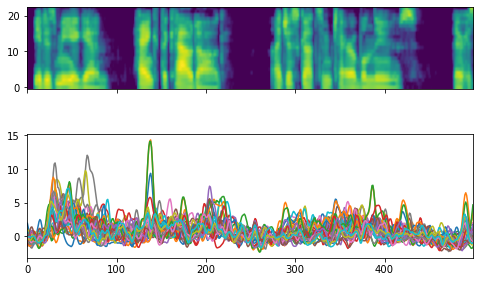

In [4]:
# Let's look at the first 5 seconds more closely

fig, axes = plt.subplots(2,1,figsize=(8,5), sharex=True)
axes[0].imshow(out[0]['aud'][:500].T, origin='lower', aspect=4)

axes[1].plot(out[0]['resp'][:500])
plt.show()

## Fit STRFs

Fit STRF models that have a receptive field of 400 ms in the past

In [17]:
tmin = 0 # receptive field begins at time=0
tmax = 0.4 # receptive field ends at a lag of 0.4 seconds
sfreq = 100 # sampling frequency of data

# For the sake of the cleanliness of this notebook, we set verbose=1
# Setting verbose=2 would print lots of information
# about the cross-validation procedure while the STRFs are being computed,
# and verbose=0 would print nothing during fitting
strf_model = nl.encoding.TRF(tmin, tmax, sfreq, verbose=1)


In [18]:
# first, we normalize the responses
out['resp'] = nl.preprocessing.normalize(outstruct=out, data='resp')

In [19]:
# train model on the first 16 trials 
out_train = out[:16]
out_test = out[16:]

### Fit STRFs with default model params

- 'Ridge' regularization, default set of alphas

In [20]:
# Now, fit the model to the training data. This model with contain
# 30 STRFs, one for each output channel in resp

strf_model.fit(outstruct=out_train, X='aud', y='resp')


100%|██████████| 30/30 [02:10<00:00,  4.35s/it]


TRF(alpha=[100.0, 1000.0, 10000.0, 100000.0, 1000000.0, 10000000.0, 100000000.0,
           1000000000.0],
    sfreq=100.0, tmax=0.4, tmin=0)

### Fit STRFs with different regularization

- 'Laplacian' regularization, modified range of alphas

In [21]:
# We can also change things like the regularization type, and even the range of
# regularization alphas for the cross-validation procedure. By default, the
# model is fit with 'ridge' regularization

strf_model_2 = nl.encoding.TRF(tmin, tmax, sfreq, reg_type='laplacian', alpha=np.logspace(2,10,8), verbose=1)
strf_model_2.fit(outstruct=out_train, X='aud', y='resp')


100%|██████████| 30/30 [02:10<00:00,  4.34s/it]


TRF(alpha=array([1.00000000e+02, 1.38949549e+03, 1.93069773e+04, 2.68269580e+05,
       3.72759372e+06, 5.17947468e+07, 7.19685673e+08, 1.00000000e+10]),
    reg_type='laplacian', sfreq=100.0, tmax=0.4, tmin=0)

## Analyze the STRFs

In [22]:
# compute correlation scores for the withheld test data

scores = strf_model.score(outstruct=out_test, X='aud', y='resp')
scores_2 = strf_model_2.score(outstruct=out_test, X='aud', y='resp')

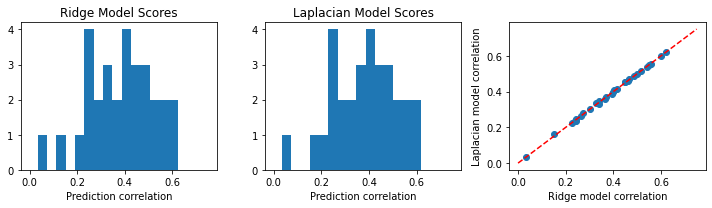

In [23]:
# compare the scores from each model's predictions

fig, axes = plt.subplots(1,3,figsize=(10,3), sharex=True)
axes[0].hist(scores, 15)
axes[0].set_xlabel('Prediction correlation')
axes[0].set_title('Ridge Model Scores')
axes[1].hist(scores_2, 15)
axes[1].set_xlabel('Prediction correlation')
axes[1].set_title('Laplacian Model Scores')
axes[2].scatter(scores, scores_2)
axes[2].set_xlabel('Ridge model correlation')
axes[2].set_ylabel('Laplacian model correlation')
axes[2].plot([0,0.75],[0,0.75],'r--')
plt.tight_layout()
plt.show()


In [24]:
# we can access the STRF weights through the .coef_ attribute of the model
coef_ridge = strf_model.coef_
coef_laplacian = strf_model_2.coef_

print(f'STRF shape (num_outputs, frequency, lag) = {coef_ridge.shape}')


STRF shape (num_outputs, frequency, lag) = (30, 23, 40)


### Visualize the STRF for each electrode

We can see that the Laplacian-regularized model gives a smoother STRF

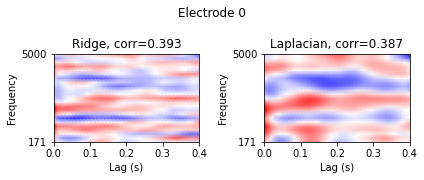

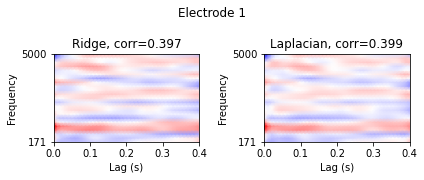

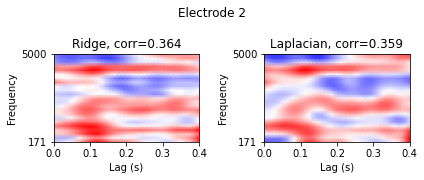

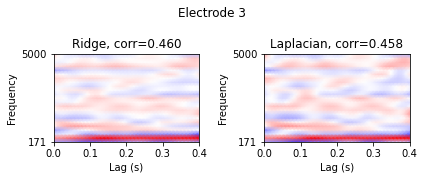

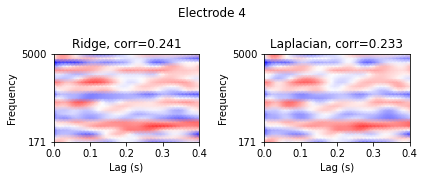

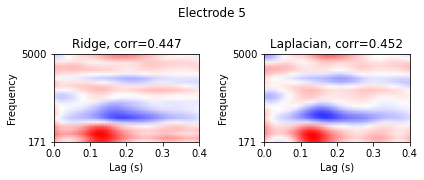

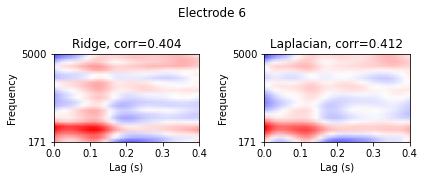

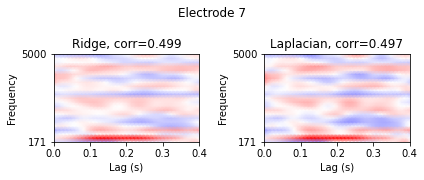

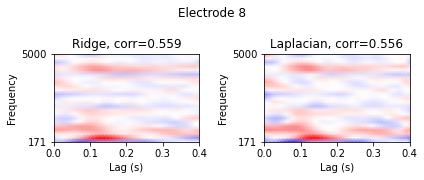

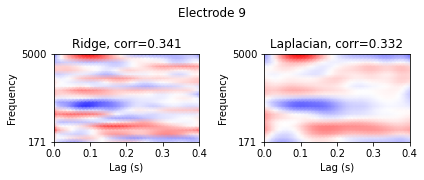

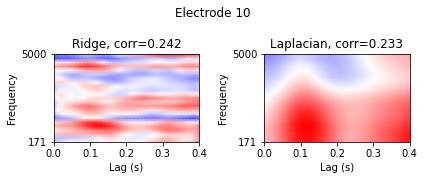

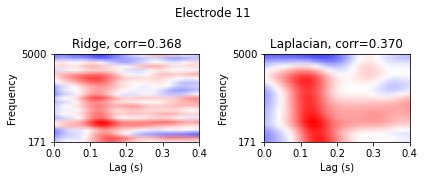

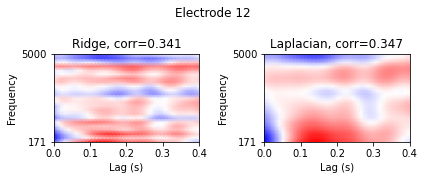

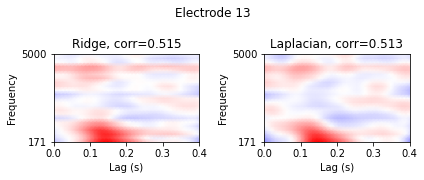

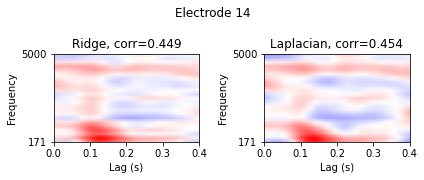

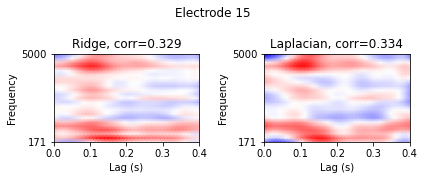

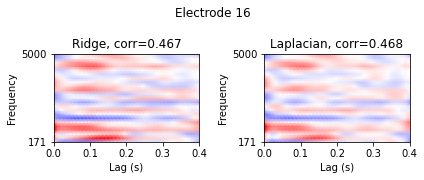

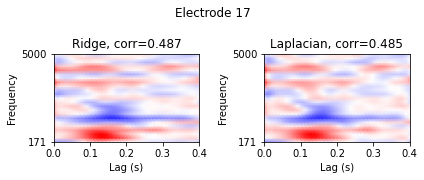

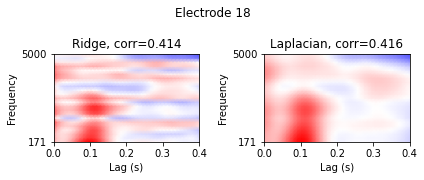

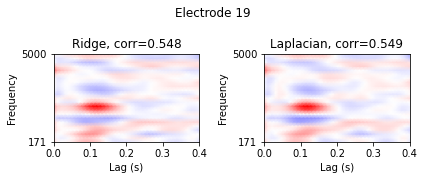

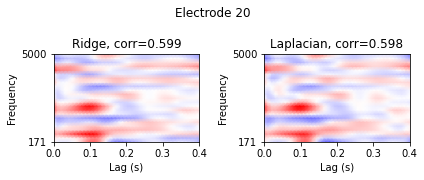

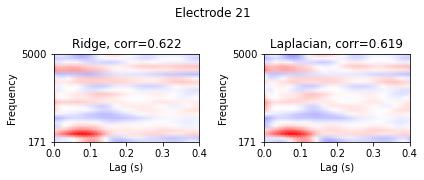

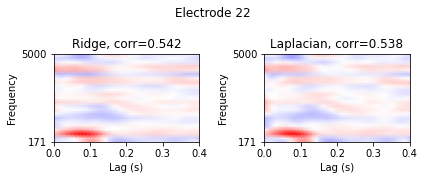

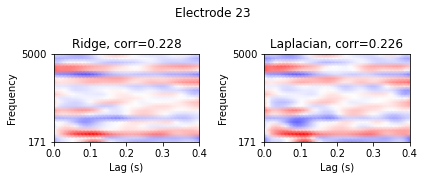

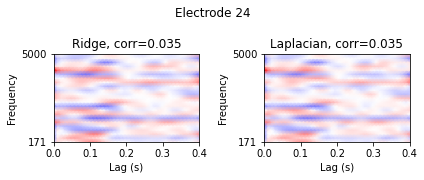

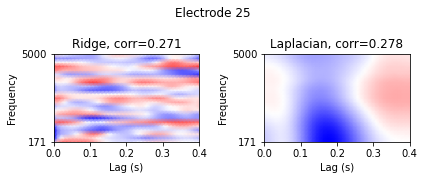

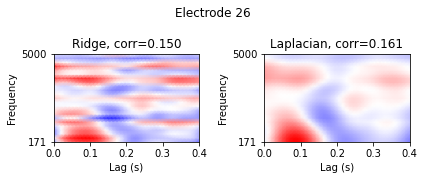

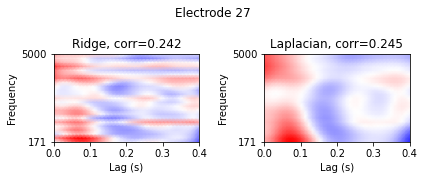

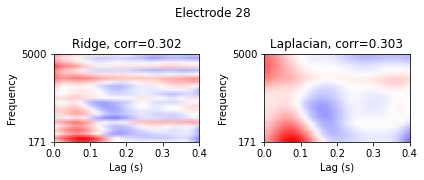

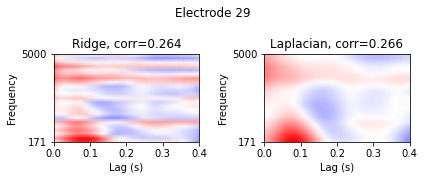

In [26]:
# Now, visualize the STRF weights for each electrode and for each model
from naplib.visualization import imSTRF


freqs = [171, 5000]

for elec, (model_1_coef, model_2_coef, score_model_1, score_model_2) in enumerate(zip(coef_ridge, coef_laplacian, scores, scores_2)):
    fig, axes = plt.subplots(1,2,figsize=(6,2.5))
    imSTRF(model_1_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[0])
    axes[0].set_title('Ridge, corr={:2.3f}'.format(score_model_1))
    imSTRF(model_2_coef, tmin=tmin, tmax=tmax, freqs=freqs, ax=axes[1])
    axes[1].set_title('Laplacian, corr={:2.3f}'.format(score_model_2))
    fig.suptitle(f'Electrode {elec}')
    fig.tight_layout()
    plt.show()
    
    

### Compute and Plot STRF Predictions

We see that the two STRF models have nearly identical predictions for most electrodes

In [27]:
predictions = strf_model.predict(outstruct=out_test, X='aud') # this is a list of the same length as out_test
predictions_2 = strf_model_2.predict(outstruct=out_test, X='aud')

# shapes of predictions for each trial 
print([x.shape for x in predictions])

[(2829, 30), (2836, 30)]


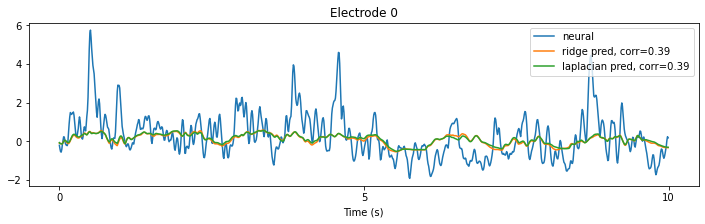

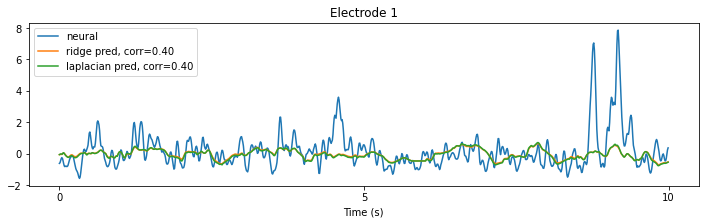

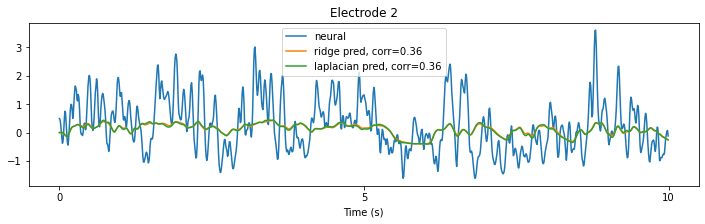

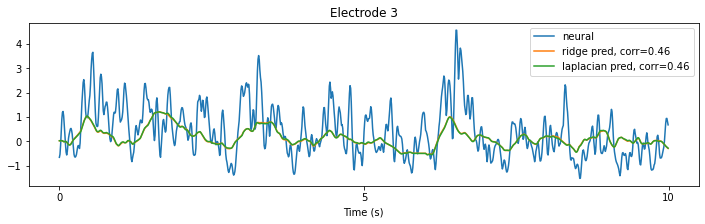

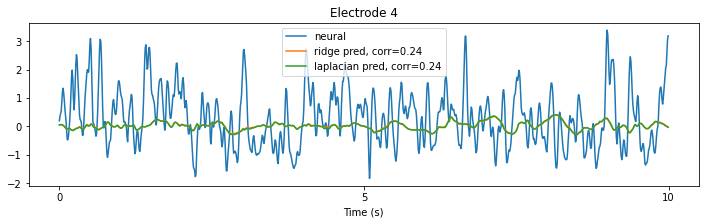

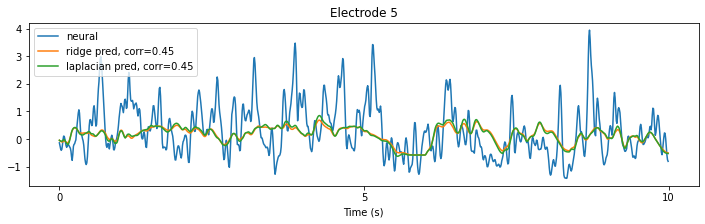

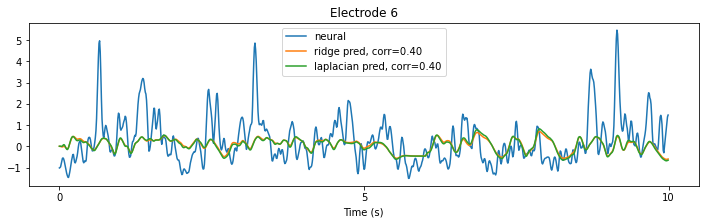

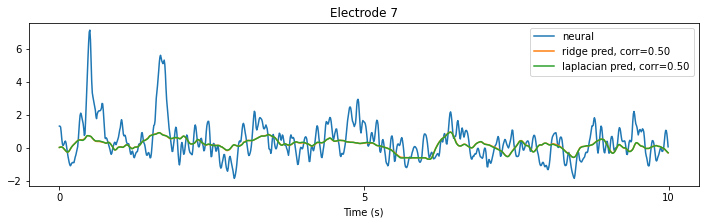

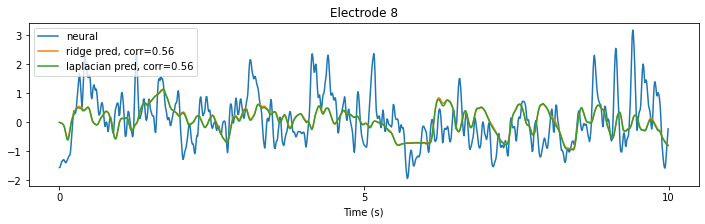

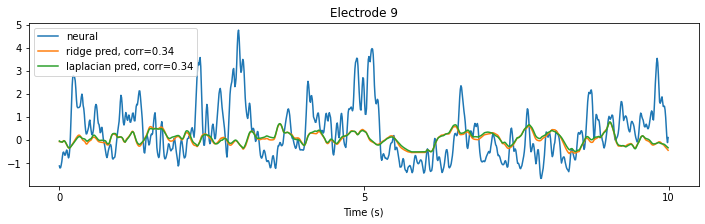

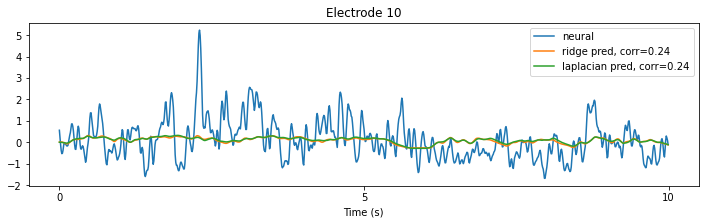

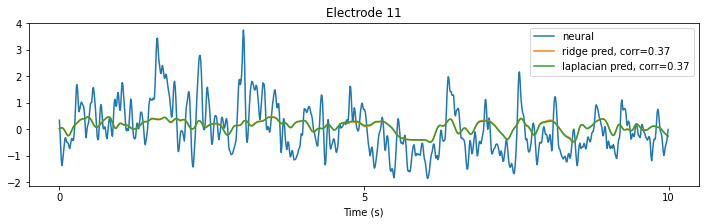

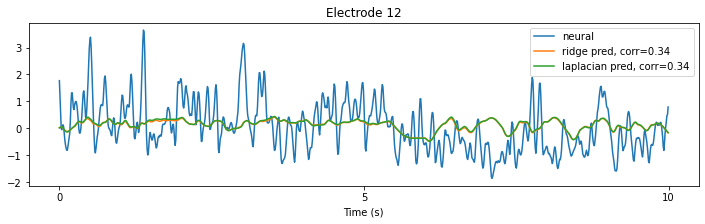

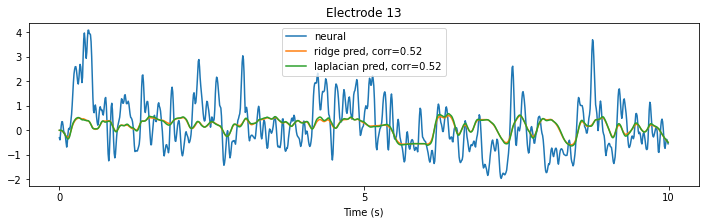

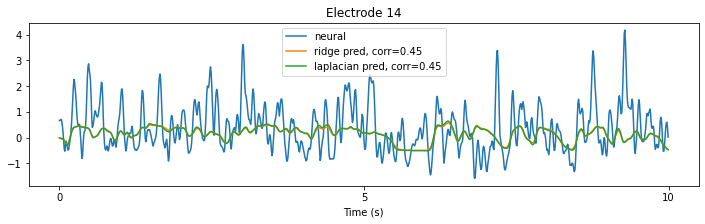

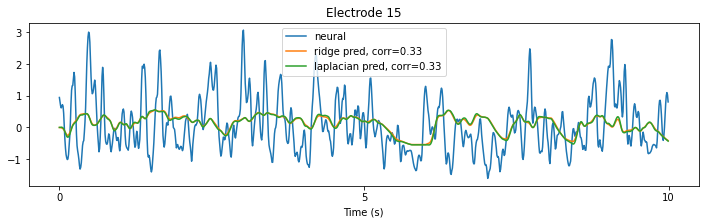

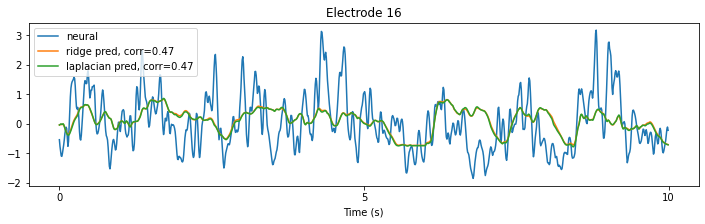

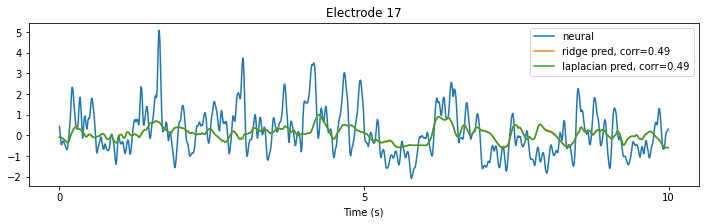

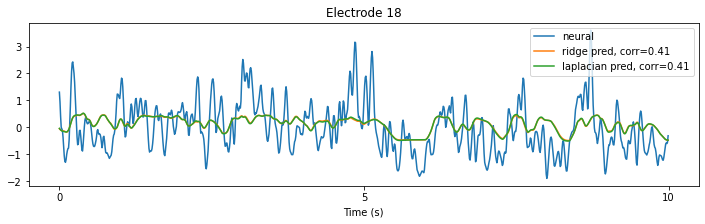

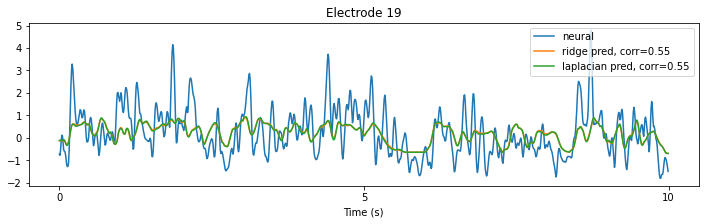

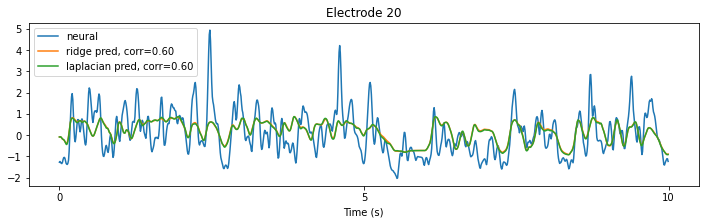

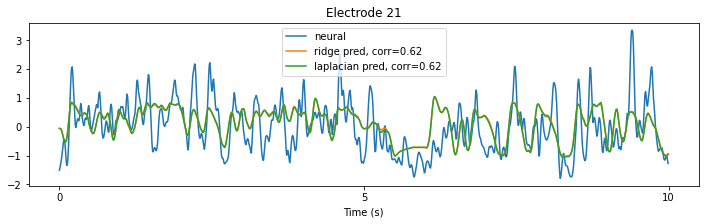

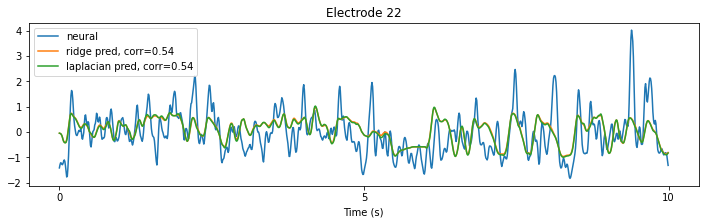

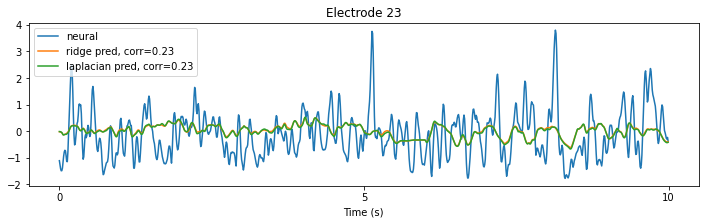

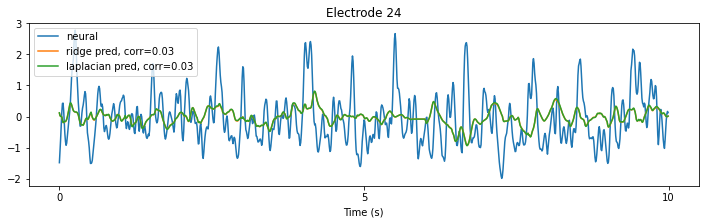

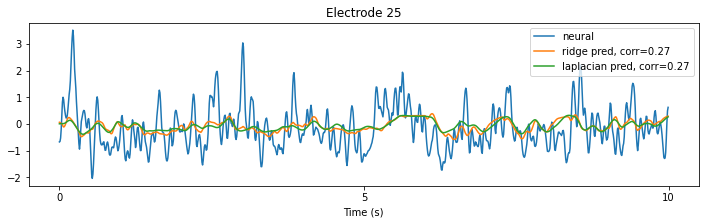

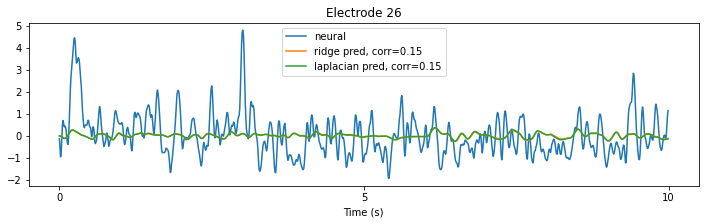

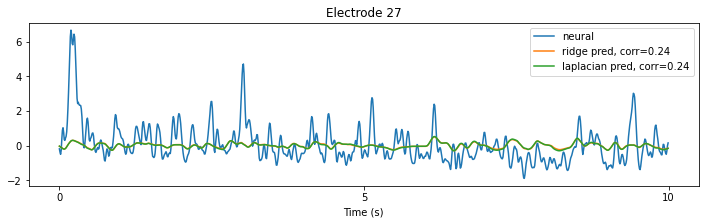

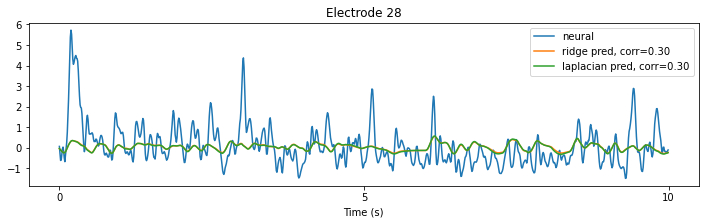

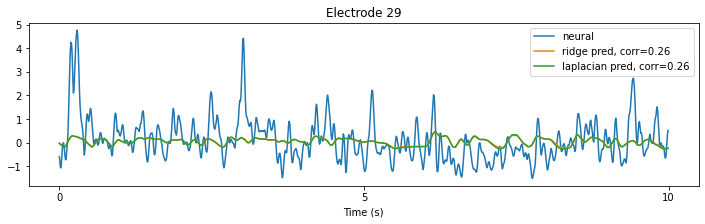

In [28]:
# plot the predictions for the first 10 seconds of the final trial for each electrode

for elec in range(predictions[0].shape[1]):

    plt.figure(figsize=(12,3))
    plt.plot(out_test['resp'][-1][:1000,elec], label='neural')
    plt.plot(predictions[-1][:1000,elec], label='ridge pred, corr={:2.2f}'.format(scores[elec]))
    plt.plot(predictions_2[-1][:1000,elec], label='laplacian pred, corr={:2.2f}'.format(scores[elec]))
    plt.xticks([0, 500, 1000], ['0', '5', '10'])
    plt.xlabel('Time (s)')
    plt.legend()
    plt.title(f'Electrode {elec}')
    plt.show()


